#Data Pre-Processing

##Import package and csv

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv(r"/content/EasyVisa.csv")
# Print shape of dataset
print(df.shape)

(25480, 12)


##Data Cleaning

* Handling Missing values
* Handling Duplicates
* Check data type
* Understand the dataset

##Check Null Values

In [16]:
df.isnull().sum()

,0
case_id,0
continent,0
education_of_employee,0
has_job_experience,0
requires_job_training,0
no_of_employees,0
yr_of_estab,0
region_of_employment,0
prevailing_wage,0
unit_of_wage,0


* **There are no null values in the dataset**

### 3.2 Other Data Cleaning steps

**Handling Duplicates**

In [17]:
df.duplicated().sum()

0

* **No Duplicates in the dataset**

**Remove case_id from the dataset as it cannot used in Model Training**

In [18]:
df.drop(columns='case_id', inplace=True, axis=1)

In [19]:
df.head(5)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [20]:
# importing date class from datetime module
from datetime import date

# creating the date object of today's date
todays_date = date.today()
current_year= todays_date.year

In [21]:
df['company_age'] = current_year-df['yr_of_estab']

In [22]:
df.drop('yr_of_estab', inplace=True, axis=1)

### Type of Features

**Numeric Features**

In [23]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Number of numerical variables: ', len(numeric_features))

Number of numerical variables:  3


**Categorical Features**

In [24]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Number of categorical variables: ', len(categorical_features))

Number of categorical variables:  8


**Discrete features**

In [25]:
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

Num of Discrete Features : 0


**Continious features**

In [26]:
continious_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continious Features :',len(continious_features))

Num of Continious Features : 3


## Split X and Y

* **Split Dataframe to X and y**
* **Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the “Case_Status” column.**


In [27]:
X = df.drop('case_status', axis=1)
y = df['case_status']

**Manual encoding the target column**

In [28]:
# If the target column has Denied it is encoded as 1 others as 0
y= np.where(y=='Denied', 1,0)

## Feature Transformation

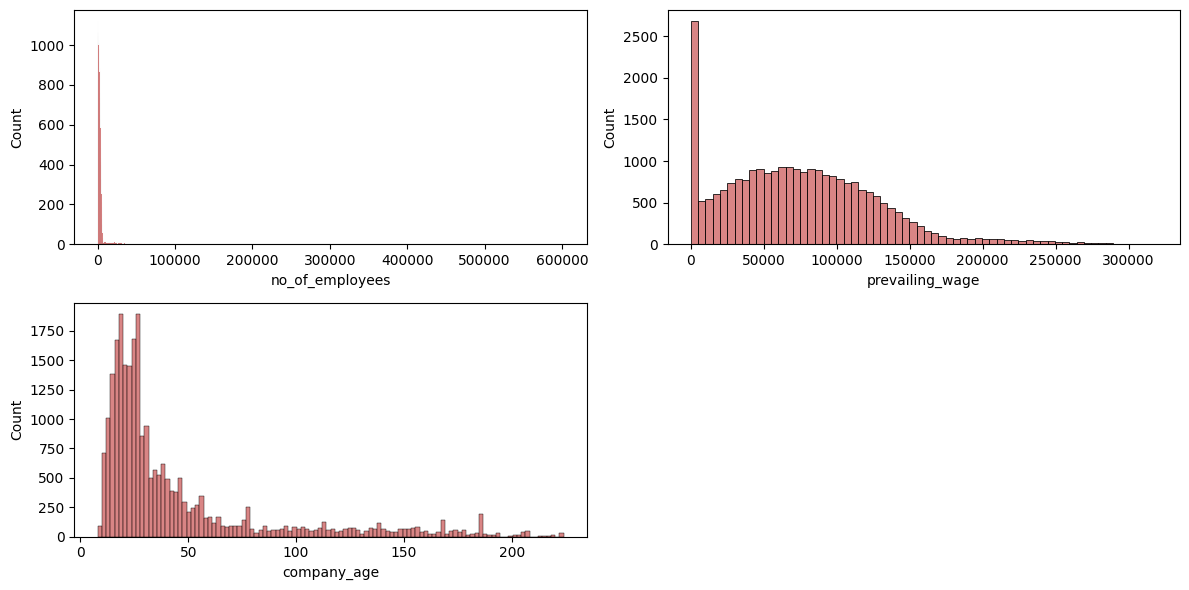

In [29]:
# distribution of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(['no_of_employees','prevailing_wage','company_age']):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=X[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

* No of employees and Copmany age column is skewed
* Apply a power transform featurewise to make data more Gaussian-like.

Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

Currently, PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform.

**Checking skewness**

In [30]:
# Check Skewness
X[continious_features].skew(axis=0, skipna=True)

,0
no_of_employees,12.265260
prevailing_wage,0.755776
company_age,2.037301


- Positiviely Skewed : company_age, no_of_employees.
- We can handle outliers and then check the skewness.

## Apply Power Transformer to Check if it can reduces the outliers

In [31]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
transform_features = ['company_age', 'no_of_employees']
X_copy = pt.fit_transform(X[transform_features])

In [32]:
X_copy = pd.DataFrame(X_copy, columns=transform_features)

In [33]:
X_copy.head()

,company_age,no_of_employees
0,-0.952162,1.517300
1,-0.462942,0.030912
2,-1.075820,2.885076
3,1.629178,-1.343550
4,-0.733953,-0.432287


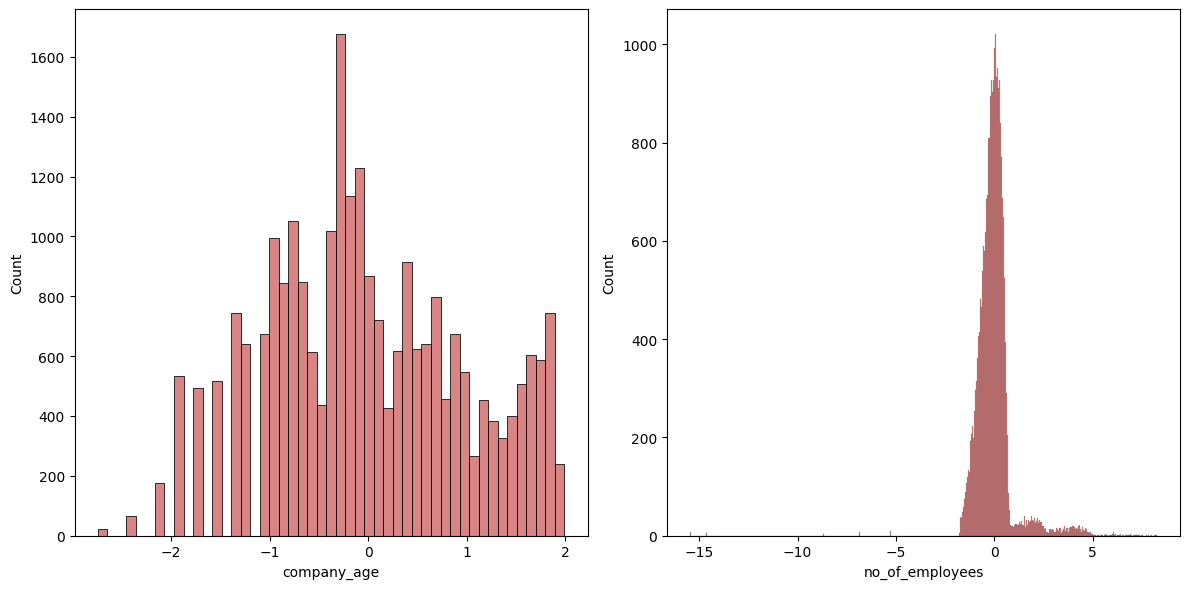

In [34]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(transform_features):
  plt.subplot(1,2,i+1)
  sns.histplot(x=X_copy[col], color='indianred')
  plt.xlabel(col)
  plt.tight_layout()

**Checking Skewness**

In [35]:
X_copy.skew(axis=0, skipna=True)

,0
company_age,0.103264
no_of_employees,0.399339


- Here Yeo-Johnson is used and it supports both positive or negative data for transformation.
- So Power Transformer with yeo-johnson can be used.

In [36]:
for feature in categorical_features:
    print(feature,':', df[feature].nunique())

continent : 6
education_of_employee : 4
has_job_experience : 2
requires_job_training : 2
region_of_employment : 5
unit_of_wage : 4
full_time_position : 2
case_status : 2


## Feature Encoding and Scaling

 **One Hot Encoding for Columns which had lesser unique values and not ordinal**
* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Ordinal Encoding for Columns which has many unique categories**
* Ordinal encoding is used here as label encoder is supported for column transformer.
* Ordinal encoding is used for Ordinal Variable. Variable comprises a finite set of discrete values with a ranked ordering between values.

**Standard Scaler**
* Standardize features by removing the mean and scaling to unit variance.

**Power Transformer**
* Power transforms are a technique for transforming numerical input or output variables to have a Gaussian or more-Gaussian-like probability distribution.

**Selecting numerical features for preprocessing**

In [37]:
num_features = list(X.select_dtypes(exclude='object').columns)

In [38]:
num_features

['no_of_employees', 'prevailing_wage', 'company_age']

## Preprocessing using Column Transformer

In [39]:
or_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
oh_columns = ['continent','unit_of_wage','region_of_employment']
transform_columns= ['no_of_employees','company_age']

In [40]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [41]:
numeric_transformer  = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
  ])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, oh_columns),
        ("Ordinal_Encoder", ordinal_encoder, or_columns),
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [42]:
X = preprocessor.fit_transform(X)

In [43]:
X

array([[ 0.        ,  1.        ,  0.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  0.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 0.        ,  1.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  0.        , ..., -0.10805575,
        -0.06776315,  0.45814768]])

In [44]:
from imblearn.combine import SMOTETomek, SMOTEENN
smt = SMOTEENN(random_state=42, sampling_strategy='minority')
#fit the model to genearate the data
X_res, y_res = smt.fit_resample(X, y)

In [45]:
from sklearn.model_selection import  train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((13638, 24), (3410, 24))

In [48]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [49]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [50]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()

}

In [51]:
# Create a function which can evaluate models and return a report
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    models_list = []
    accuracy_list = []
    auc= []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1))
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')

    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)

    return report

In [52]:
base_model_report =evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9557
- F1 score: 0.9592
- Precision: 0.9584
- Recall: 0.9600
- Roc Auc Score: 0.9553


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9287
- F1 score: 0.9342
- Precision: 0.9350
- Recall: 0.9335
- Roc Auc Score: 0.9283


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8822
- F1 score: 0.8903
- Precision: 0.8945
- Recall: 0.8862
- Roc Auc Score: 0.8819
----------------------------------
Model performance for Test set
- Accuracy: 0.8956
- F1 score: 0.9031
- Precision: 0.9095
- Recall: 0.8967
- Roc Auc Score: 0.8955


Logistic Regression
Model performance for Training 

**Results of All Models**

In [53]:
base_model_report

,Model Name,Accuracy
0,Random Forest,0.955718
4,K-Neighbors Classifier,0.940176
5,XGBClassifier,0.935191
6,CatBoosting Classifier,0.929619
1,Decision Tree,0.928739
2,Gradient Boosting,0.895601
7,Support Vector Classifier,0.870088
8,AdaBoost Classifier,0.868328
3,Logistic Regression,0.744868


**Here we can use Random Forest for Hyper Parameter Tuning**

**Define the parameter distribution for Random forest**

In [54]:
#Initialize few parameter for Hyperparamter tuning
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}

In [55]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]

**Create a function for model training and report which can be used in hyperparameter tuning loop**

In [56]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
---------------- Best Params for XGBoost -------------------
{'min_child_weight': 1, 'max_depth': 9}
---------------- Best Params for RF -------------------
{'n_estimators': 200, 'max_features': 'log2', 'max_depth': None}
---------------- Best Params for KNN -------------------
{'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'auto'}


## Retraining the Model with best Parameters

In [57]:
from sklearn.metrics import roc_auc_score,roc_curve
best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['KNN']),
    "XGBClassifier": XGBClassifier(**model_param['XGBoost'],n_jobs=-1),
}
tuned_report =evaluate_models(X=X_res, y=y_res, models=best_models)

Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9569
- F1 score: 0.9603
- Precision: 0.9590
- Recall: 0.9616
- Roc Auc Score: 0.9565


KNeighborsClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9733
- F1 score: 0.9757
- Precision: 0.9651
- Recall: 0.9865
- Roc Auc Score: 0.9721


XGBClassifier
Model performance for Training set
- Accuracy: 0.9995
- F1 score: 0.9995
- Precision: 0.9993
- Recall: 0.9997
- Roc Auc Score: 0.9995
----------------------------------
Model performance for Test set
- Accuracy: 0.9455
- F1 score: 0.9498
- Precision: 0.9487
- Recall: 0.9508
- Roc Auc Score: 0.9450




In [58]:
tuned_report

,Model Name,Accuracy
1,KNeighborsClassifier,0.973314
0,Random Forest Classifier,0.956891
2,XGBClassifier,0.945455


In [59]:
best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9733
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1561
           1       0.97      0.99      0.98      1849

    accuracy                           0.97      3410
   macro avg       0.97      0.97      0.97      3410
weighted avg       0.97      0.97      0.97      3410



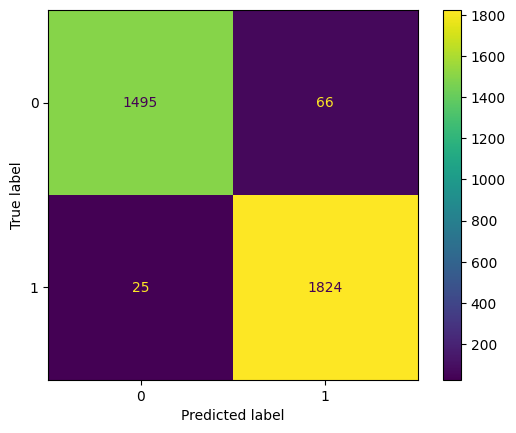

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

## Best Model is K-Nearest Neighbor(KNN) with Accuracy 96.66%